# Dog breed classification

This project is about training and deploying a model which can classify a dog breed for a given image.
I use a dataset hosted by Udacity: [dogImages](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). It consists of images of 133 (!) dog breeds.

This notebook is divided into sections:
* Dataset. I explain what the dataset is, show some sample images and statistics and discuss what can make this project difficult.
* Hyperparameter Tuning
* Model Profiling and Debugging
* Model Deploying

## Imports

In [5]:
!pip install smdebug --quiet
!pip install --upgrade bokeh==2.4.3 --quiet

In [42]:
import sagemaker
import boto3
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from sagemaker.pytorch import PyTorch
from sagemaker.session import TrainingInput
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    rule_configs,
)

In [7]:
sns.set_theme()

## Dataset

THe dataset contains .jpg images of dogs, which are classified into 133 different classes. Each class has its own subfolder and the data is already divided into train/, valid/ and test/ sets.

There are 6680 train images, 835 validation images and 836 test images.

In [8]:
# I comment this out because it enough to download it once
# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate
# !unzip dogImages.zip

In [9]:
from pathlib import Path
images_base_path = Path("./dogImages/")

def count_class_size(folder: str):
    data_path = images_base_path / folder
    class_iterator = (path for path in data_path.iterdir() if path.is_dir())
    class_size_counter = {}
    for class_folder in class_iterator:
        n_images = len(list(class_folder.glob("*.jpg")))
        class_size_counter[class_folder.name] = n_images

    return class_size_counter

train_classes = count_class_size("train")
val_classes = count_class_size("valid")
test_classes = count_class_size("test")

print(f"Number of classes: {len(train_classes.keys())}")
assert len(train_classes.keys()) == len(val_classes.keys()) == len(test_classes.keys())

print(f"Number of train images: {sum(train_classes.values()):>10}")
print(f"Number of validation images: {sum(val_classes.values()):>4}")
print(f"Number of test images: {sum(test_classes.values()):>10}")

Number of classes: 133
Number of train images:       6680
Number of validation images:  835
Number of test images:        836


In [10]:
print(f"Average number of train images per class: {sum(train_classes.values()) / len(train_classes.keys()) :.0f}")

Average number of train images per class: 50


The classes don't have equal size. The biggest class has 77 training images, and the smallest 26 training images. On average there is training 50 images per class.

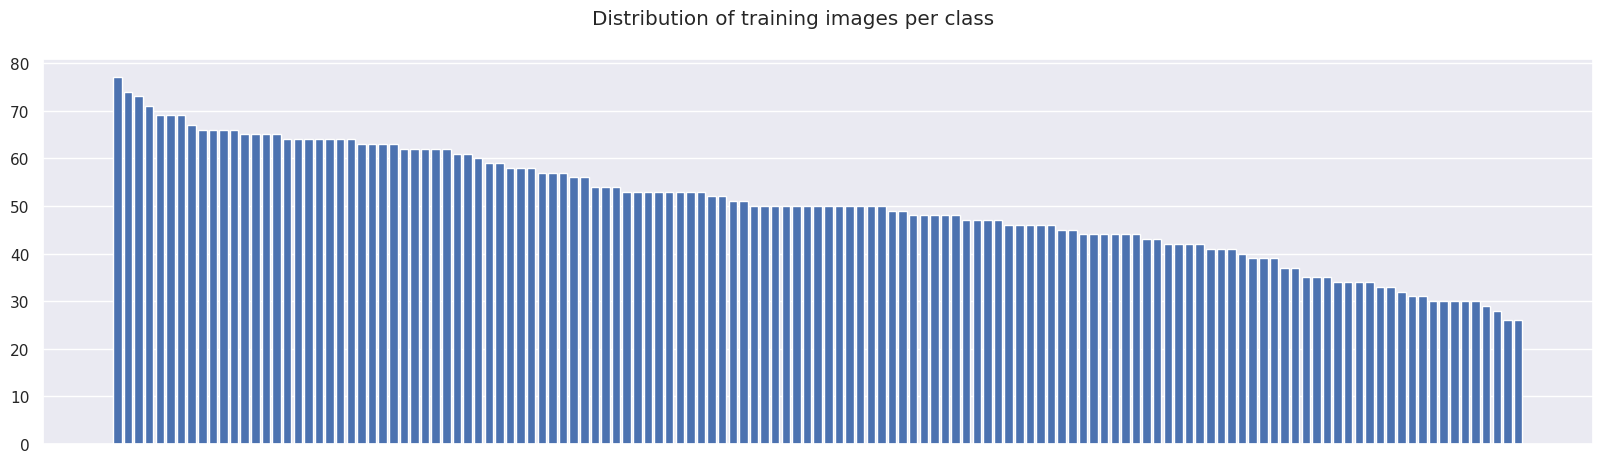

In [11]:
train_class_size_sorted = sorted(train_classes.values(), reverse=True)

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(train_class_size_sorted)), train_class_size_sorted)
ax.get_xaxis().set_visible(False)
fig.suptitle("Distribution of training images per class")
plt.show()

Few samples per each class might make this problem difficult to solve. Especially when paired with the fact, that some of the breeds are similar, and some dogs of the same breed look differently (they might have different color). Please, take a look at the images below. The model needs to classify all three images as the same class!

<table>
  <tr>
    <td align="center">
      <img src="images/Cavalier_king_charles_spaniel_03302.jpg" alt="Left Image"><br>
      <em>Blenheim (chestnut and white)</em>
    </td>
    <td align="center">
      <img src="images/Cavalier_king_charles_spaniel_03300.jpg" alt="Center"><br>
      <em>Tricolour (black/white/tan)</em>
    </td>
    <td align="center">
      <img src="images/Cavalier_king_charles_spaniel_03247.jpg" alt="Right Image"><br>
      <em>Black and tan</em>
    </td>
  </tr>
    <em>Fig: Cavalier King Charles Spaniel comes in a variety of colors. However, they are all beutiful!</em>
</table>

## Hyperparameter Tuning

I use the `hpo.py` script to perform hyperparameter tuning.

I decide to tune three parameters:
* learning rate
* weight decay
* batch size

I use [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) to train the model. It's an algorithm which adaptively adjust the momentum, so that it doesn't overshoot when it's close to a local minimum.
This means that there are not so many parameters to tune, because the algorithm itself adjust to the situation. 

The most important one is the `learning rate`, which defines the initial speed of training. The default value for Adam is $0.001$. I try a range of values from $0.001$ to $0.1$.
I decide not to tune $\beta_1$ and $\beta_2$. Their default values are considered to be good in most cases. I also think that tuning such parameters makes sense if one uses a lot of HPO trials.
In this case I run just 16 training jobs, to not exceed the budget.

However, I decide to tune `weight decay`, which is also called [$L2$ penalty](https://en.wikipedia.org/wiki/Regularization_(mathematics)). It helps in preventing overfitting. But because I train only one linear layer (the ResNet weights are frozen) I don't want this penalty to be too big, to not shrink my weights towards 0. That's why a try a range of values from $0$ to only $10^{-5}$.

The last parameter I tune is `batch size`. I try values $64$, $128$ and $256$. I don't want to use values smaller than $64$, because the usage of the GPU machine costs money and smaller batches would underutilize the GPU. I don't try larger values than 256 because I thought that it might not fit on the chepeast GPU machine I use here.

I train each model for $5$ epochs. The number of epochs could also be tuned. However, I don't want to let the model run for too long - again for money constaint.
I run 16 different training jobs, so that it has a chance to try different combinations of `learning rate`, `weight decay` and `batch size`. 
I train each model on `"ml.g4dn.xlarge"` machine, which I found to be the chepeast EC2 instance with GPU (see [pricing](https://aws.amazon.com/sagemaker-ai/pricing/)).
As I will see after the tuning job is completed, each individual job takes around 7 minutes.

In [50]:
hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([64, 128, 256]),
    "weight-decay": ContinuousParameter(0.0, 1e-5),
}

In [51]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [52]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    framework_version="1.13",
    py_version="py39",
    hyperparameters={
         "epochs": "5",
    }
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=16,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [48]:
sess = sagemaker.Session()
bucket_name = sess.default_bucket()

dataset_prefix = f"s3://{bucket_name}/datasets/dogImages"

In [54]:
tuner.fit(
    {
        "training": TrainingInput(f"{dataset_prefix}/train/", distribution="FullyReplicated"),
        "test": TrainingInput(f"{dataset_prefix}/valid/", distribution="FullyReplicated"),
    },
    wait=True
)

[04/10/25 11:12:38] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=990626;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=762191;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    WARNING  No finished training job found associated with this estimator.       ]8;id=975430;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=54163;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=126043;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=808884;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=586948;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=109614;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=948155;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=976835;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#3383\3383]8;;\
                             pytorch-training-250410-1112                                                          

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [55]:
best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()


2025-04-10 12:01:32 Starting - Found matching resource for reuse
2025-04-10 12:01:32 Downloading - Downloading the training image
2025-04-10 12:01:32 Training - Training image download completed. Training in progress.
2025-04-10 12:01:32 Uploading - Uploading generated training model
2025-04-10 12:01:32 Completed - Resource reused by training job: pytorch-training-250410-1112-013-cb52bdd9


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '"5"',
 'learning-rate': '0.007304133573457823',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2025-04-10-11-12-37-961"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-10-11-12-37-961/source/sourcedir.tar.gz"',
 'weight-decay': '5.039936927695963e-06'}

### Plot results of the tuning

The tuner object contains a data frame with the results of each training job.
Thanks to it I can analyze the impact on the test loss of each parameter I tuned.

The plots are generated and shown  down below.
I firstly plot the `batch size` and `learning rate` jointly, because I think that they are quite correlated. At least in theory larger batch size would allow using larger learning rate.
The plot shows that the tuner quickly decided to use the largest possible batch size: in 11 out of 16 trials. For the learning rate it looks like it converged into exploring values around $0.1$

I write "the tuner decided" because by default it uses the Bayesian Tuner, which doesn't try hyperparameters values completely at random, but it uses information from previous runs to narrow down the search space to most promising areas.

I also plot `weight decay` vs `learning rate`. However this time the impact of weight decay is less clear. 
It looks like the tuner was exploring the weight decay values evenly through entire available range and it found low test loss for a few different values.

Later I plot influence of `weight decay` and `learning rate` individually 

In [164]:
tuner_loss["batch-size"].value_counts()

batch-size
256    11
128     3
64      2
Name: count, dtype: int64

In [163]:
tuner_loss = tuner.analytics().dataframe()
tuner_loss["batch-size"] = tuner_loss["batch-size"].str.replace('"', '').astype("int")
tuner_loss.head(3)

,batch-size,learning-rate,weight-decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,256,0.004031,0.000009,pytorch-training-250410-1112-016-033cb121,Completed,0.003284,2025-04-10 12:09:10+00:00,2025-04-10 12:16:00+00:00,410.0
1,128,0.005399,0.000007,pytorch-training-250410-1112-015-5eb2753b,Completed,0.004873,2025-04-10 12:09:07+00:00,2025-04-10 12:16:02+00:00,415.0
2,256,0.007843,0.000002,pytorch-training-250410-1112-014-280e54e5,Completed,0.002936,2025-04-10 12:01:28+00:00,2025-04-10 12:08:23+00:00,415.0


In [98]:
metric_value = tuner_loss["FinalObjectiveValue"]

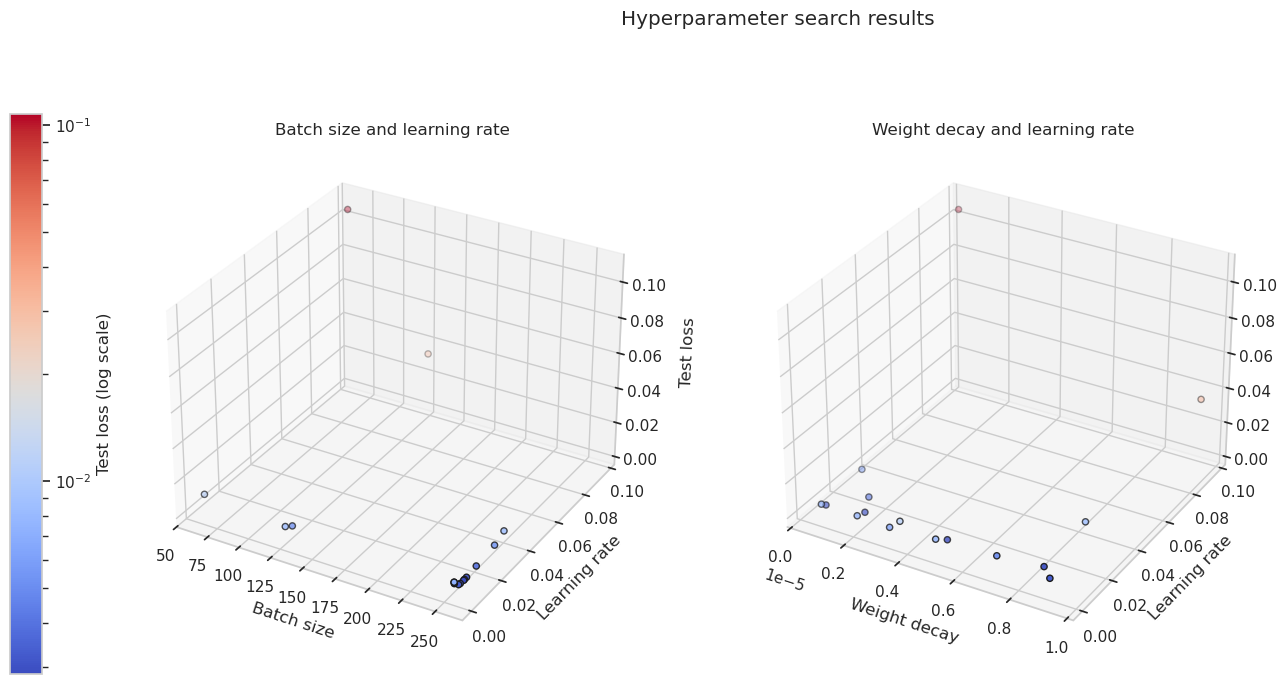

In [156]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={"projection": "3d"})

# Normalize color scale across both plots
norm = LogNorm(
    vmin=metric_value.min(), vmax=metric_value.max()
)
cmap = plt.cm.coolwarm

# Left 3D scatter plot
sc1 = axs[0].scatter(
    tuner_loss["batch-size"],
    tuner_loss["learning-rate"],
    metric_value,
    c=metric_value,
    cmap=cmap,
    norm=norm,
    edgecolor="k"
)
axs[0].set_title("Batch size and learning rate")

# Right 3D scatter plot
sc2 = axs[1].scatter(
    tuner_loss["weight-decay"],
    tuner_loss["learning-rate"],
    metric_value,
    c=metric_value,
    cmap=cmap,
    norm=norm,
    edgecolor="k"
)
axs[1].set_title("Weight decay and learning rate")

axs[0].set_xlabel("Batch size")
axs[1].set_xlabel("Weight decay")
for ax in axs:
    ax.set_ylabel("Learning rate")
    ax.set_zlabel("Test loss", labelpad=10)

# Add a common color bar
cbar_ax = fig.add_axes([0.02, 0.15, 0.02, 0.7])  # Position color bar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label("Test loss (log scale)")

# Show plot
fig.suptitle("Hyperparameter search results")
fig.subplots_adjust(left=0.1, right=0.8)
plt.show()

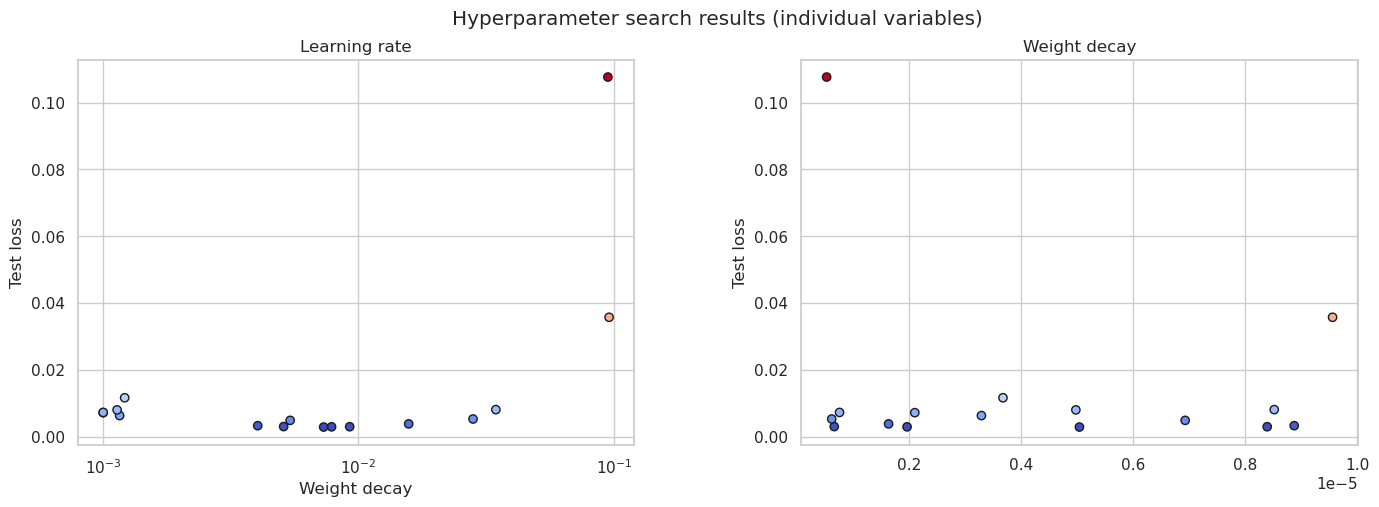

In [158]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sc1 = axs[0].scatter(
    tuner_loss["learning-rate"],
    metric_value,
    c=metric_value,
    cmap=cmap,
    norm=norm,
    edgecolor="k"
)
axs[0].set_title("Learning rate")
axs[0].set_xlabel("Learning rate (log scale)")
axs[0].set_xscale("log")

sc2 = axs[1].scatter(
    tuner_loss["weight-decay"],
    metric_value,
    c=metric_value,
    cmap=cmap,
    norm=norm,
    edgecolor="k"
)
axs[1].set_title("Weight decay")
axs[0].set_xlabel("Weight decay")

for ax in axs:
    ax.set_ylabel("Test loss")

# Show plot
fig.suptitle("Hyperparameter search results (individual variables)")
fig.subplots_adjust(left=0.1, right=0.9, wspace=0.3)
plt.show()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(
        rule_configs.loss_not_decreasing(),
        rule_parameters={
            "num_steps": "1",
            "diff_percent": "100",
            "increase_threshold_percent": "0",
            "patience": "1"
        }
    ),

    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "1", "eval.save_interval": "10"}
)

In [159]:
best_hyperparameters = {
    'batch-size': "256",
    'epochs': "5",
    'learning-rate': '0.007304133573457823',
    'weight-decay': '5.039936927695963e-06',
    "log-interval": "2",
}

In [ ]:
# TODO: Create and fit an estimator

# I tried using `framework_version="2.5"`, but it doesn't have smdebug installed
# The "ml.t3.large" instance is sufficient for testing the estimator with batch-size: 16 on resnet18.
# I tested ml.g4dn.xlarge on ReNet50 with up to 256 batch-size

estimator = PyTorch(
    entry_point="train_model.py",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    # instance_type="ml.m5.xlarge",
    instance_type="ml.t3.large",
    # instance_type="ml.g4dn.xlarge",
    framework_version="1.13",
    py_version="py39",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
)

estimator.fit(
    {
        "training": TrainingInput("s3://sagemaker-us-east-1-007260079220/datasets/dogImages/train/", distribution="FullyReplicated"),
        "test": TrainingInput("s3://sagemaker-us-east-1-007260079220/datasets/dogImages/valid/", distribution="FullyReplicated"),
    },
    wait=True
)

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [20]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [21]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-08-23-39-14-222/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-08-23-39-14-222/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-08-23-39-14-222/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-08-23-39-14-222/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-08-23-39-14-2

In [22]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [23]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()